# Individual models for X3
In this notebook I'll look at individual models fo value groups on 'X3'.<br>
This notebook is part of my Mercedes-Benz Kaggle efforts. Competion @: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing Use of data subject to conditions mentioned in above link.

In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import string
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import Matern
#from sklearn.grid_search import GridSearchCV

## 1. Load Data Sets

In [2]:
df_train = pd.read_csv('../data/train.csv').drop(['ID'],1).fillna(0)
df_train = df_train[df_train['y'] < 200] # drop one outlier data
df_test = pd.read_csv('../data/test.csv', index_col = 'ID').fillna(0)
li_del_columns = []

## 2. Construct additional features and change letter categorical to binary
This is not applicable for X3, as I'll be dividing the datasets on this feature to train individual models.

In [3]:
def my_dummies(c, df1, df2):
    l = len(df1)
    df = pd.concat([df1, df2], axis = 0)
    df_temp = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df_temp, df], axis = 1)
    df = df.drop(c, axis = 1)
    df1 = df[ : l].copy()
    df2 = df[l : ].copy()
    return df1, df2

In [47]:
li_columnNames = [e for e in list(df_train.columns.values) if e not in {'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'}]
li_categorical = ['X0', 'X1', 'X2', 'X4', 'X5', 'X6', 'X8'] # X3 excluded as I'll be using this as argument to divide the dataset
list_value = list(string.lowercase) + list('a' + x for x in list(string.lowercase)) + ['ba', 'bb', 'bc']

df_train_eng = df_train.copy()
df_test_eng = df_test.copy()
df_train_eng['qty_options'] = df_train_eng[li_columnNames].sum(axis=1)
df_test_eng['qty_options'] = df_test_eng[li_columnNames].sum(axis=1)
#df_train_eng['y_actual'] = df_train_eng['y'] * df_train_eng['qty_options'] #let's hold this one for later, it will become obvious why

for c in li_categorical:
    df_train_eng, df_test_eng = my_dummies(c, df_train_eng, df_test_eng)


## 3. some data clensing / Identifying data for possible clensing

### Identify duplicate columns

In [48]:
all_data = pd.concat((df_train_eng, df_test_eng))

# remove duplicated columns
c = all_data.columns
print('\n Number of columns before cleaning: %d' % len(c))
li_duplicates = []
for i in range(len(c)-1):
    v = all_data[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,all_data[c[j]].values):
            li_duplicates.append(c[j])
            print(' Column %s is identical to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))
li_duplicates = list(set(li_duplicates))
print '\n Number of identified duplicates marked: %s' % len(li_duplicates)


 Number of columns before cleaning: 575
 Column X2_a is identical to X32. Removing X32
 Column X2_ac is identical to X125. Removing X125
 Column X2_ac is identical to X227. Removing X227
 Column X2_ad is identical to X107. Removing X107
 Column X2_ag is identical to X30. Removing X30
 Column X2_ai is identical to X215. Removing X215
 Column X2_am is identical to X260. Removing X260
 Column X2_ap is identical to X16. Removing X16
 Column X2_aq is identical to X211. Removing X211
 Column X2_as is identical to X251. Removing X251
 Column X2_at is identical to X184. Removing X184
 Column X2_at is identical to X262. Removing X262
 Column X2_au is identical to X59. Removing X59
 Column X2_aw is identical to X213. Removing X213
 Column X2_aw is identical to X67. Removing X67
 Column X2_b is identical to X26. Removing X26
 Column X2_d is identical to X97. Removing X97
 Column X2_f is identical to X23. Removing X23
 Column X2_g is identical to X112. Removing X112
 Column X2_g is identical to X

### Dropping duplicate columns
(yes there are columns duplicate and complimentary)

In [49]:
print 'Number columns before cleaning: ', df_train_eng.shape[1],
l = len(df_train_eng)
df = pd.concat([df_train_eng, df_test_eng], axis = 0)
for c in li_duplicates:
    df.drop(c, axis=1, inplace = True)

df_train_eng = df[ : l].copy()
df_test_eng = df[l : ].copy()
print 'and after cleaning: ', df_train_eng.shape[1]

Number columns before cleaning:  575 and after cleaning:  513


### Identify complementary columns

In [50]:
list_index = [e for e in list(df_train_eng.columns.values) if e not in {'y_actual', 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'}]
all_data = pd.concat((df_train_eng[list_index], df_test_eng[list_index]))
value_compliment = {0: 1, 1: 0}

# remove complimentary columns
c = all_data.columns
print('\n Number of columns before cleaning: %d' % len(c))
li_compliments = []
for i in range(len(c)-1):
    v = all_data[c[i]].replace(value_compliment).values
    for j in range(i+1,len(c)):
        if np.array_equal(v,all_data[c[j]].values):
            li_compliments.append(c[j])
            print(' Column %s is complimentary to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))
li_compliments = list(set(li_compliments))
print '\n Number of identified complements marked: %s' % len(li_compliments)


 Number of columns before cleaning: 511
 Column X128 is complimentary to X130. Removing X130
 Column X156 is complimentary to X157. Removing X157
 Column X204 is complimentary to X205. Removing X205
 Column X232 is complimentary to X263. Removing X263

 Number of identified complements marked: 4


### Droping complementary columns


In [51]:
print 'Number columns before cleaning: ', df_train_eng.shape[1],
l = len(df_train_eng)
df = pd.concat([df_train_eng, df_test_eng], axis = 0)
for c in li_compliments:
    df.drop(c, axis=1, inplace = True)

df_train_eng = df[ : l].copy()
df_test_eng = df[l : ].copy()
print 'and after cleaning: ', df_train_eng.shape[1]

Number columns before cleaning:  513 and after cleaning:  509


### let's see if we have same datarows (other then y and y_actual) in train data
<font color=red>SKIP TO "GENERATING MORE DATA" IF LOADING PRE-PROCESSED DATASET. THIS STEP TAKES TIME!</font>

In [9]:
li_columns = [e for e in list(df_train_eng.columns.values) if e not in {'y_actual', 'y'}]
df = df_train_eng[li_columns]
li_seen_duplicates = []
li_duplicates = []
print 'start finding...'
for i in range(len(df)):
    if i not in li_seen_duplicates:
        set_pairs = {}
        v = df.iloc[i, :].values
        for j in range(i+1,len(df)):
            if np.array_equal(v,df.iloc[j, :].values):
                if i not in li_seen_duplicates: li_seen_duplicates.append(i)
                li_seen_duplicates.append(j)
                if i not in set_pairs: set_pairs[i] = df_train_eng.ix[df_train_eng.index.tolist()[i],'y']
                set_pairs[j] = df_train_eng.ix[df_train_eng.index.tolist()[j],'y']
        if set_pairs: li_duplicates.append(set_pairs)
    if i % 100 == 0: print '.',
for i in range(len(li_duplicates)):
    values = li_duplicates[i].values()
    print '\n Row IDs ', list(li_duplicates[i].keys()), ' mean: ', sum(values) / len(values),
    if len(values) > 3:
        print ', mean minus extremes: ', (sum(values) - min(values) - max(values)) / (len(values) - 2),

start finding...
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 Row IDs  [16, 130, 51, 13, 79]  mean:  96.788 , mean minus extremes:  94.9366666667 
 Row IDs  [18, 93]  mean:  94.36 
 Row IDs  [32, 98, 106, 45, 23, 90, 123, 29, 95]  mean:  115.602222222 , mean minus extremes:  115.131428571 
 Row IDs  [38, 30]  mean:  77.505 
 Row IDs  [37, 85]  mean:  113.84 
 Row IDs  [72, 58, 110]  mean:  101.196666667 
 Row IDs  [64, 77]  mean:  110.455 
 Row IDs  [146, 158]  mean:  108.26 
 Row IDs  [147, 235]  mean:  105.965 
 Row IDs  [196, 167]  mean:  111.17 
 Row IDs  [304, 183]  mean:  88.235 
 Row IDs  [184, 208]  mean:  78.225 
 Row IDs  [228, 187, 204, 277]  mean:  98.01 , mean minus extremes:  98.43 
 Row IDs  [192, 232]  mean:  101.47 
 Row IDs  [306, 198]  mean:  89.735 
 Row IDs  [209, 263]  mean:  109.755 
 Row IDs  [280, 311]  mean:  96.38 
 Row IDs  [419, 370, 500, 409, 346, 349, 446]  mean:  91.8885714286 , mean minus extremes:  91.984 
 Ro

True, this is a relatively simplistic approach, and I might revisit later to take into consideration a more pronounced outlier detection in lieu of removing both extremes. For now let's leave it at this.

Next let's set the values for all identical row sets to the mean or mean minus extremes if more than 3 values.

In [10]:
if 'y_orig' not in df_train_eng.columns: df_train_eng['y_orig'] = df_train_eng['y'] # preserve the original value for "true" evaluation at the end
for i in range(len(li_duplicates)):
    values = li_duplicates[i].values()
    if len(values) > 3:
        mean = (sum(values) - min(values) - max(values)) / (len(values) - 2)
    if len(values) <= 3:
        mean = sum(values) / len(values)
    for j in list(li_duplicates[i].keys()):
        df_train_eng.set_value(j ,'y', mean)


In [11]:
df_train_eng[(df_train_eng['y'] != df_train_eng['y_orig'])]

,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,...,X91,X93,X94,X95,X96,X98,X99,qty_options,y,y_orig
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,52,94.936667,94.12
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,52,94.936667,106.10
18,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,62,94.360000,89.81
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,58,115.131429,120.77
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,58,115.131429,128.19
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,58,77.505000,76.01
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,58,115.131429,106.87
37,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,58,113.840000,117.31
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,58,77.505000,79.00
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,58,115.131429,110.52


Write out the dataframe as is to load in this state if required.

In [12]:
df_train_eng.to_csv(path_or_buf='../data/train_eng_y_orig.csv', index_label='ID', header=True)

### generating some more training data
the amount of data considering the binary features is not much, hence let's produce some more.
I figure I'll be adding 10 rows for each pre-existing row: I'll be adding / subtracting a small percentage (probably 1% times number of rows away from start) from the goal y value. The average of the rowset stays the same; the variance is smaller to what I have seen in the dataset earlier (see checking for identical rows and the y values). This should afford me sufficient data to get good model fitting.

In [128]:
df_train_eng = pd.read_csv('../data/train_eng_y_orig.csv', index_col = 0)

In [13]:
df_add = pd.DataFrame.from_items([(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df_train_eng.iteritems()])
df_add = pd.DataFrame(data = None, columns=df_train_eng.columns)
y_index = df_train_eng.columns.get_loc('y')
add_vals = 10
add_factor = 0.01
add_range = range(-(add_vals/2), 0) + range(1, (add_vals/2) + 1)
for i in range(len(df_train_eng)):
    values = list(df_train_eng.iloc[i,:])
    li_add = []
    for j in add_range:
        li_add.append(values[:])
        li_add[len(li_add)-1][y_index] = values[y_index]*(1 + j*add_factor)
    df_add = df_add.append(pd.DataFrame(li_add, columns=df_train_eng.columns))


In [14]:
df_train_eng = pd.concat([df_train_eng, df_add], axis = 0)
df_train_eng.shape


(46288, 510)

In [15]:
df_train_eng['y_actual'] = df_train_eng['y'] * df_train_eng['qty_options'] # Remember that one from further up? Now you see why.

In [16]:
df_train_eng.to_csv(path_or_buf='../data/train_eng_y_XL.csv', index_label='ID', header=True)

In [52]:
df_train_eng = pd.read_csv('../data/train_eng_y_XL.csv', index_col = 0)

## First let's have at single model against the whole dataset

In [23]:
list_all = list(df_test_eng.columns.values)
list_all.remove('X3')
list_all.remove('y')
#list_all.remove('y_orig')
#list_all.remove('y_actual')
list_test = list_all
list_train = ['y_actual'] + list_test
df_X = df_train_eng[list_train].copy()
df_Kaggle = df_test_eng[list_test].copy()
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=997)


ValueError: list.remove(x): x not in list

r^2:  0.796437400036


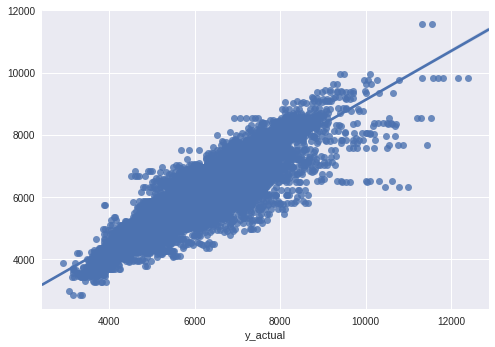

In [20]:
#model = MLPRegressor(hidden_layer_sizes=(140,140,140,140), max_iter = 300)
#model = RandomForestRegressor(n_estimators = 1200, min_samples_leaf=6)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print 'r^2: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

In [122]:
y_Kaggle = pd.Series(model.predict(df_Kaggle) / df_test_eng['qty_options'], name='y', index=df_Kaggle.index)
y_Kaggle.to_csv(path='../data/201706161550.linreg.csv', index_label='ID', header = True)

All three are not very good, but have one thing in common I really like: far less extreme outliers!

### Divide training datasets along feature X3 for individual models

In [53]:
list_value = list(string.lowercase) + list('a' + x for x in list(string.lowercase)) + ['ba', 'bb', 'bc']
i = 0
value_to_int = {}
for j in list_value:
    value_to_int[j] = i
    i += 1
df_train_eng = df_train_eng.replace(value_to_int).copy()
df_test_eng = df_test_eng.replace(value_to_int).copy()
for i in range(7):
    print 'X3 equals ', i, ' mean y:',
    print df_train_eng[(df_train_eng['X3'] == i)]['y'].mean(), ' y_actual:',
    print df_train_eng[(df_train_eng['X3'] == i)]['y_actual'].mean(), ' Datasets:',
    print df_train_eng[(df_train_eng['X3'] == i)].shape[0]

X3 equals  0  mean y: 102.668481061  y_actual: 6259.94034091  Datasets: 4840
X3 equals  1  mean y: 99.3411637427  y_actual: 5561.44164912  Datasets: 627
X3 equals  2  mean y: 101.823267005  y_actual: 6107.83528101  Datasets: 21362
X3 equals  3  mean y: 104.500327586  y_actual: 5898.07782184  Datasets: 3190
X3 equals  4  mean y: 100.793425358  y_actual: 5794.04149284  Datasets: 1793
X3 equals  5  mean y: 97.1788666667  y_actual: 5251.94830853  Datasets: 11825
X3 equals  6  mean y: 100.65033195  y_actual: 5894.18603734  Datasets: 2651


based on the y values and the y_actual values (which is a product of y and qty_options), 4 groups will be build: 0 and 2; 1, 4 and 6; 3; 5

In [54]:
df_test_eng_0 = df_test_eng[((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2))]
df_test_eng_1 = df_test_eng[((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6))]
df_test_eng_3 = df_test_eng[(df_test_eng['X3'] == 3)]
df_test_eng_5 = df_test_eng[(df_test_eng['X3'] == 5)]
df_train_eng_0 = df_train_eng[((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2))]
df_train_eng_1 = df_train_eng[((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6))]
df_train_eng_3 = df_train_eng[(df_train_eng['X3'] == 3)]
df_train_eng_5 = df_train_eng[(df_train_eng['X3'] == 5)]


In [55]:
print 'Group 0, 2 mean y: ', df_train_eng_0['y'].mean(), ' y_actual: ', df_train_eng_0['y_actual'].mean(), ' Datasets: ', df_train_eng_0.shape[0]
print 'Group 1, 4, 6 mean y: ', df_train_eng_1['y'].mean(), ' y_actual: ', df_train_eng_1['y_actual'].mean(), ' Datasets: ', df_train_eng_1.shape[0]
print 'Group 3 mean y: ', df_train_eng_3['y'].mean(), ' y_actual: ', df_train_eng_3['y_actual'].mean(), ' Datasets: ', df_train_eng_3.shape[0]
print 'Group 5 mean y: ', df_train_eng_5['y'].mean(), ' y_actual: ', df_train_eng_5['y_actual'].mean(), ' Datasets: ', df_train_eng_5.shape[0]

Group 0, 2 mean y:  101.979393867  y_actual:  6135.93193355  Datasets:  26202
Group 1, 4, 6 mean y:  100.539055676  y_actual:  5817.63508098  Datasets:  5071
Group 3 mean y:  104.500327586  y_actual:  5898.07782184  Datasets:  3190
Group 5 mean y:  97.1788666667  y_actual:  5251.94830853  Datasets:  11825


0, 2:  0.91884523343


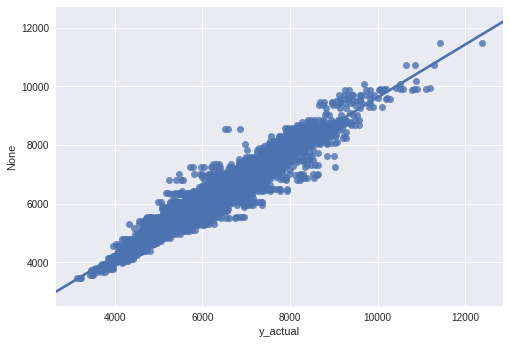

1, 4, 6:  0.943525366605


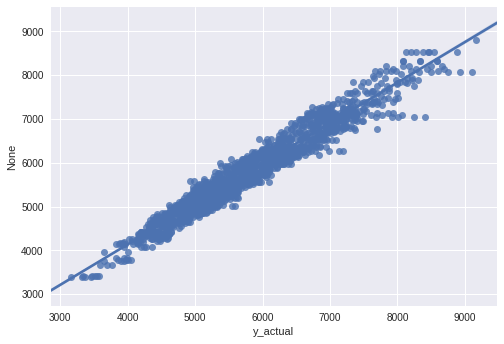

3:  0.946663196481


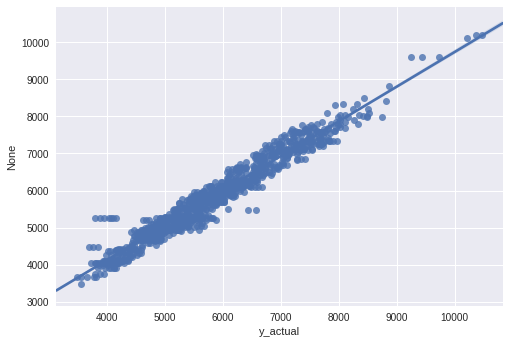

5:  0.930992903842


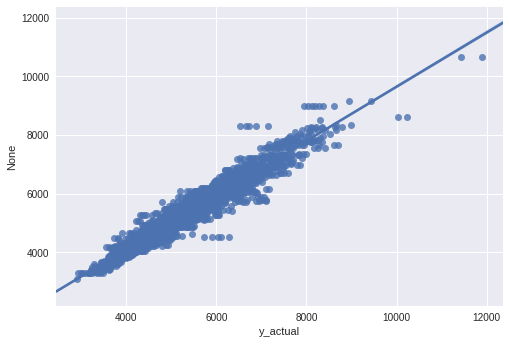

all:  0.934316797573


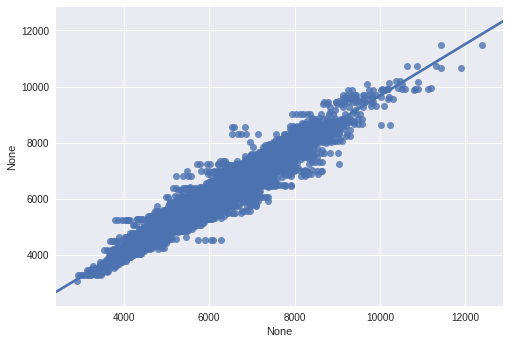

In [76]:
list_index = list(df_test_eng.columns.values)
list_index.remove('y')
list_test = list_index
list_train = ['y_actual'] + list_test
df_X = df_train_eng_0[list_train]
df_Kaggle = df_test_eng_0[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '0, 2: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_1[list_train]
df_Kaggle = df_test_eng_1[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '1, 4, 6: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_3[list_train]
df_Kaggle = df_test_eng_3[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '3: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_5[list_train]
df_Kaggle = df_test_eng_5[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '5: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all / df_Kaggle_all['qty_options'], name='y', index=df_Kaggle_all.index)
#output_Kaggle.to_csv(path='../data/201706162125.X3_models.ranFor.csv', index_label='ID', header = True)

## From the discussion forum: it appears treating y > 120 differently helps.
So how do the same graphics look like if I ommit the >120?

0, 2:  0.926719515964


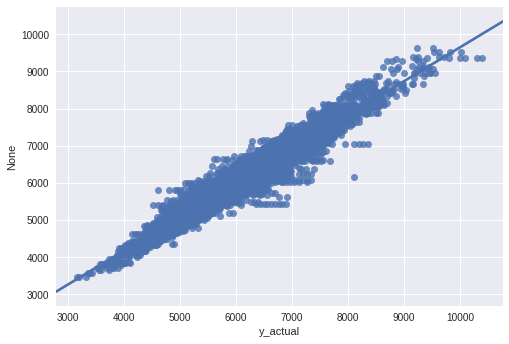

1, 4, 6:  0.947545263549


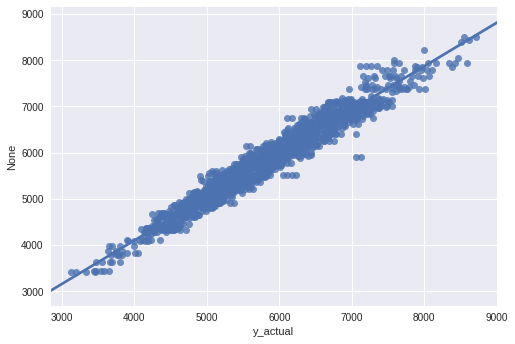

3:  0.941872997866


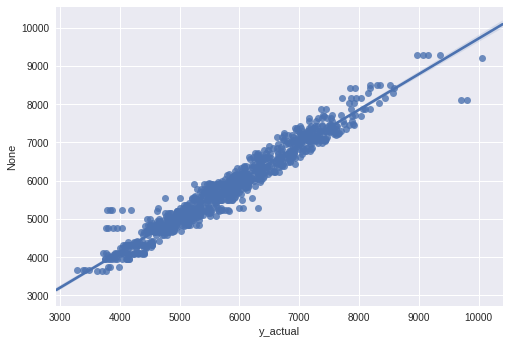

5:  0.935642827921


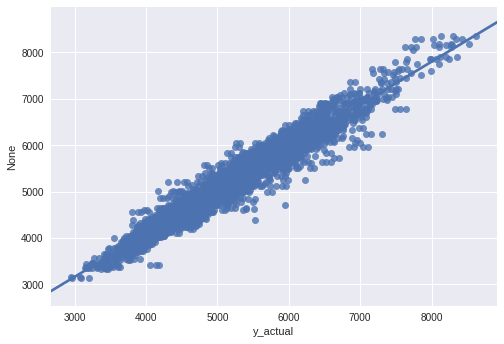

all:  0.940941816223


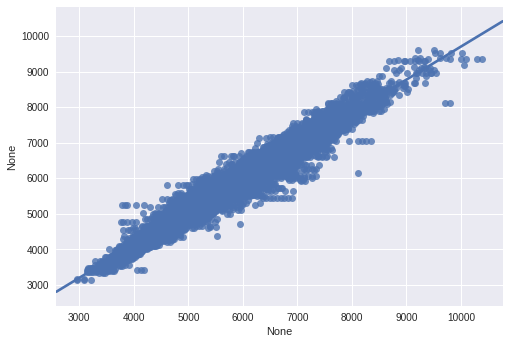

In [77]:
list_index = list(df_test_eng.columns.values)
list_index.remove('y')
list_test = list_index
list_train = ['y_actual'] + list_test
df_X = df_train_eng_0[(df_train_eng_0['y'] <= 120)][list_train]
df_Kaggle = df_test_eng_0[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '0, 2: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_1[(df_train_eng_1['y'] <= 120)][list_train]
df_Kaggle = df_test_eng_1[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '1, 4, 6: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_3[(df_train_eng_3['y'] <= 120)][list_train]
df_Kaggle = df_test_eng_3[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '3: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_5[(df_train_eng_5['y'] <= 120)][list_train]
df_Kaggle = df_test_eng_5[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '5: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all / df_Kaggle_all['qty_options'], name='y', index=df_Kaggle_all.index)
#output_Kaggle.to_csv(path='../data/201706162125.X3_models.ranFor.csv', index_label='ID', header = True)

Next stop Ridge

In [84]:
df_exp = pd.DataFrame()
df_exp['y_actual'] = y_test_all.values
df_exp['y_pred'] = y_pred_all.values

In [85]:
df_exp.head(10)

,y_actual,y_pred
0,4736.0160,4939.999052
1,7468.6848,7308.704926
2,6155.5200,5867.563658
3,6490.4130,6272.284454
4,7736.4000,7948.372951
5,7215.6420,7190.548396
6,5980.3128,6052.764212
7,7307.8110,7540.372840
8,6526.6425,6238.709709
9,4449.5332,4495.129805


0, 2:  0.835008676584


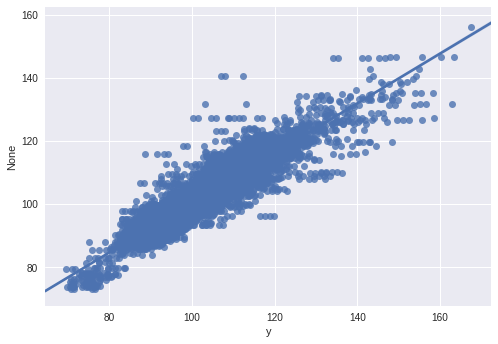

1, 4, 6:  0.851453345137


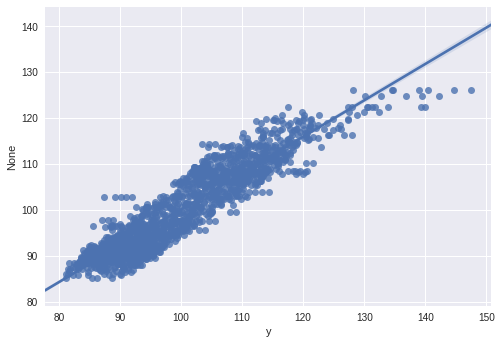

3:  0.765092992727


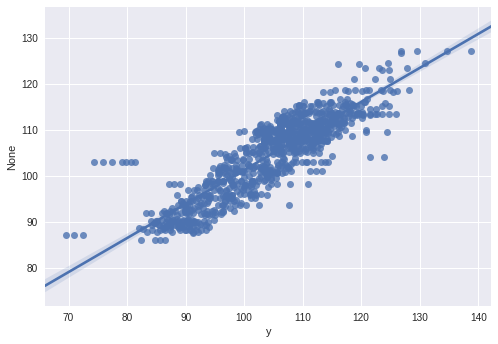

5:  0.851890100749


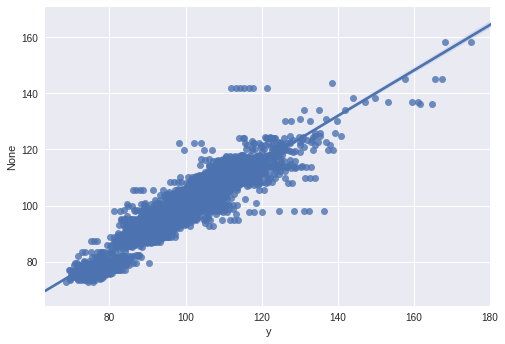

all:  0.843623140555


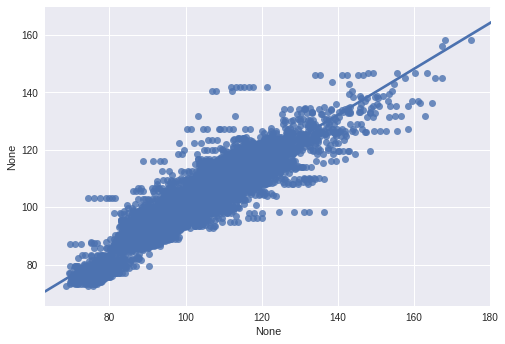

In [94]:
list_index = list(df_test_eng.columns.values)
list_index.remove('y')
list_test = list_index
list_train = ['y'] + list_test
df_X = df_train_eng_0[list_train]
df_Kaggle = df_test_eng_0[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '0, 2: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_1[list_train]
df_Kaggle = df_test_eng_1[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '1, 4, 6: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_3[list_train]
df_Kaggle = df_test_eng_3[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '3: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_5[list_train]
df_Kaggle = df_test_eng_5[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '5: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all / df_Kaggle_all['qty_options'], name='y', index=df_Kaggle_all.index)
#output_Kaggle.to_csv(path='../data/201706162125.X3_models.ranFor.csv', index_label='ID', header = True)

In [96]:
output_Kaggle = pd.Series(y_Kaggle_all, name='y', index=df_Kaggle_all.index)
output_Kaggle.to_csv(path='../data/201706171615.X3_models.ranFory.csv', index_label='ID', header = True)

0, 2:  0.825355721834


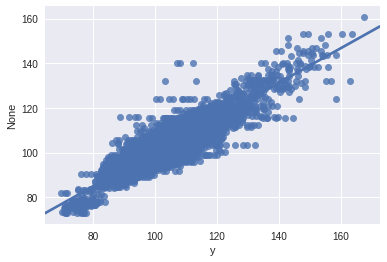

1, 4, 6:  0.890171088826


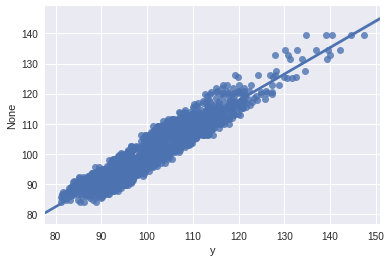

3:  0.793497064532


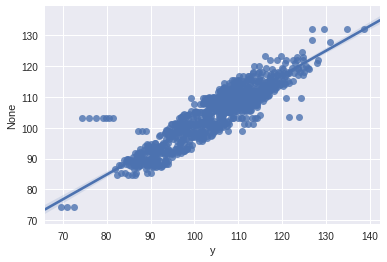

5:  0.893366432113


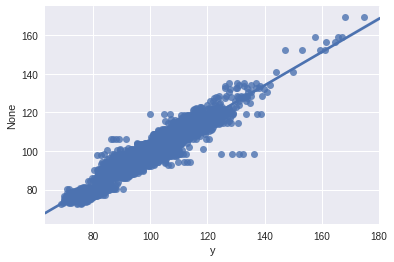

all:  0.854831874851


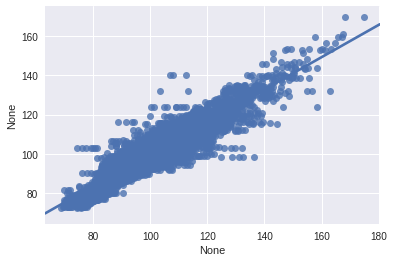

In [104]:
list_index = list(df_test_eng.columns.values)
list_index.remove('y')
list_test = list_index
list_train = ['y'] + list_test
df_X = df_train_eng_0[list_train]
df_Kaggle = df_test_eng_0[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()
#cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 'n_estimators': [200, 500, 800, 1200]}
#ind_params = {'learning_rate': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8}
cv_params = {'max_depth': [5], 'min_child_weight': [3], 'n_estimators': [500]}
ind_params = {'learning_rate': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8}
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

#model = LinearRegression(fit_intercept=False, normalize = True)
#model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
#model = xgb.XGBRegressor()
model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '0, 2: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_1[list_train]
df_Kaggle = df_test_eng_1[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
#model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
#model = xgb.XGBRegressor()
model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '1, 4, 6: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_3[list_train]
df_Kaggle = df_test_eng_3[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
#model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
#model = xgb.XGBRegressor()
model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '3: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_5[list_train]
df_Kaggle = df_test_eng_5[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
#model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
#model = xgb.XGBRegressor()
model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '5: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all, name='y', index=df_Kaggle_all.index)
output_Kaggle.to_csv(path='../data/201706171920.X3_models.xgboost.csv', index_label='ID', header = True)

[mean: 0.57355, std: 0.00662, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.67173, std: 0.00593, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.72726, std: 0.00598, params: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.77235, std: 0.00667, params: {'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.57326, std: 0.00612, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.67114, std: 0.00461, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.72696, std: 0.00594, params: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.77119, std: 0.00649, params: {'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.56740, std: 0.00880, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 5}, mean: 0.66266, std: 0.00759, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 5}, mean: 0

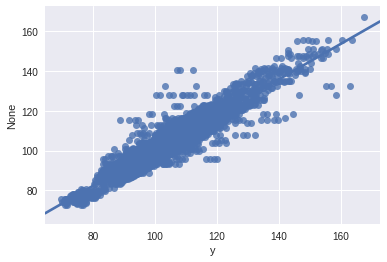

[mean: 0.76813, std: 0.00636, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.85246, std: 0.00339, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.87402, std: 0.00455, params: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.88091, std: 0.00502, params: {'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.76778, std: 0.00416, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.85153, std: 0.00210, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.87317, std: 0.00400, params: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.88070, std: 0.00491, params: {'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.75810, std: 0.00347, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 5}, mean: 0.84493, std: 0.00347, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 5}, mean: 0

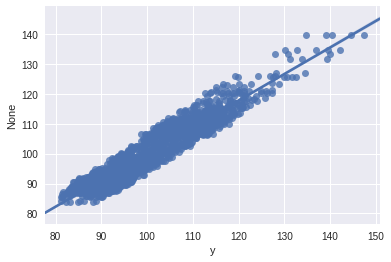

[mean: 0.78130, std: 0.03088, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.81102, std: 0.03114, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.81468, std: 0.03103, params: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.81642, std: 0.03098, params: {'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.77839, std: 0.03159, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.81081, std: 0.03113, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.81528, std: 0.03035, params: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.81628, std: 0.03097, params: {'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.77442, std: 0.03054, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 5}, mean: 0.80879, std: 0.03069, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 5}, mean: 0

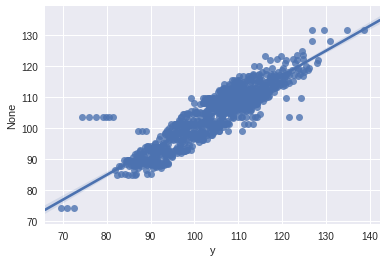

[mean: 0.72304, std: 0.02322, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.81574, std: 0.01562, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.85397, std: 0.01154, params: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.87571, std: 0.00850, params: {'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 1}, mean: 0.72086, std: 0.02437, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.81374, std: 0.01836, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.85207, std: 0.01503, params: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.87417, std: 0.01065, params: {'n_estimators': 1200, 'max_depth': 3, 'min_child_weight': 3}, mean: 0.71047, std: 0.02944, params: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 5}, mean: 0.80278, std: 0.02430, params: {'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 5}, mean: 0

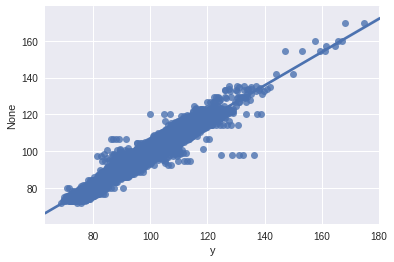

all:  0.88738491747


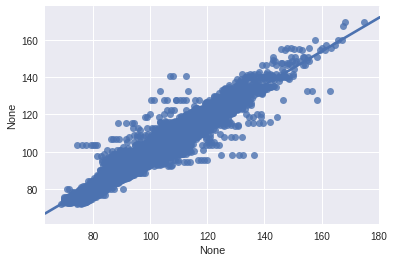

In [106]:
list_index = list(df_test_eng.columns.values)
list_index.remove('y')
list_test = list_index
list_train = ['y'] + list_test
df_X = df_train_eng_0[list_train]
df_Kaggle = df_test_eng_0[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 'n_estimators': [200, 500, 800, 1200]}
ind_params = {'learning_rate': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8}
#cv_params = {'max_depth': [5], 'min_child_weight': [3], 'n_estimators': [500]}
#ind_params = {'learning_rate': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8}
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

#model = LinearRegression(fit_intercept=False, normalize = True)
#model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
#model = xgb.XGBRegressor()
model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
model.fit(X_train, y_train)
print model.grid_scores_
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '0, 2: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_1[list_train]
df_Kaggle = df_test_eng_1[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
#model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
#model = xgb.XGBRegressor()
model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
model.fit(X_train, y_train)
print model.grid_scores_
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '1, 4, 6: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_3[list_train]
df_Kaggle = df_test_eng_3[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
#model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
#model = xgb.XGBRegressor()
model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
model.fit(X_train, y_train)
print model.grid_scores_
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '3: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

df_X = df_train_eng_5[list_train]
df_Kaggle = df_test_eng_5[list_test]
df_y = df_X['y']
df_X = df_X.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
#model = LinearRegression(fit_intercept=False, normalize = True)
#model = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=6)
#model = xgb.XGBRegressor()
model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
model.fit(X_train, y_train)
print model.grid_scores_
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
y_pred_all = y_pred_all.append(y_pred)
y_test_all = y_test_all.append(y_test)
df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
print '5: ', r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred)
plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all, name='y', index=df_Kaggle_all.index)
output_Kaggle.to_csv(path='../data/201706171920.X3_models.xgboost.csv', index_label='ID', header = True)

# Takeaways:
1. This dataset is very prone to overfitting
2. The scores for the example used on the Kaggle Leaderboard are to be taken with extreme caution; The data available for the quantity of features on average a large enough average might be suitable. But the moment the quantity of test data is getting smaller, outliers have extreme influence.
3. separating the data on X3 for individual models generally seems to improve the prediction; however the outliers are getting more grouped and pronounced, which is nice, as it means they are easier addressed.
4. Next steps:<br>
    a. repeat experiment with dividing data on X3, but at the step of mean normalisation, only ommit values that are outside a 0.90 to 1.10 * mean zone, not both, min and max.<br>
    b. experiment with first classifying if an expected value is outside a *to be defined zone* around the overall mean (one classifier above, one classifier below ?) and build extra models for those.<br>
    c. considering the original data analysis and the discussion forum, investigate with another dividing feaure: X6. If results are similar to the observations with X3, then combine (run both, build the mean of the results. build cluster of n different models. these are the prliminary ideas I have at this time.<br>
5. Next to-dos:<br>
    a. have a look at the y_orig distribution, identify threshold for 4.b.<br>
    b. identify model parameters for the X3 models to improve computing time. above results took from 19:00 to 04:17, about 9 1/3 hours.

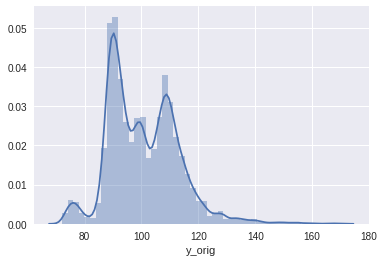

In [107]:
sns.distplot(df_train_eng['y_orig'])
plt.show()

In [108]:
df_train_eng['y_orig'].min()

72.109999999999999

In [109]:
df_train_eng['y_orig'].max()

169.91

In [110]:
df_train_eng['y_orig'].describe()

count    46288.000000
mean       100.630190
std         12.422804
min         72.110000
25%         90.817500
50%         99.150000
75%        109.010000
max        169.910000
Name: y_orig, dtype: float64

Hmmm looking at this histogram, I can see:
- a normal distribution with a few samples and a mean of around 75
- a normal distribution with a narrow sigma, numerous samples and a mean around 90
- a normal distribution with narrowish sigma, sufficient samples and a mean around 107
- a normal distribution with wide sigma, very few samples and a mean around 125-135-ish
- possibly another normal distribution with few to medium samples, narrow sigma and a mean around 100

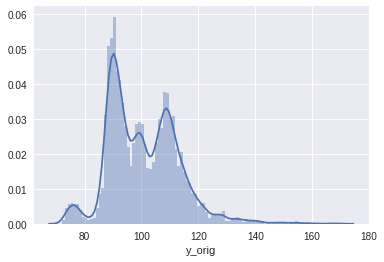

In [112]:
sns.distplot(df_train_eng['y_orig'], bins =99)
plt.show()

<function matplotlib.pyplot.show>

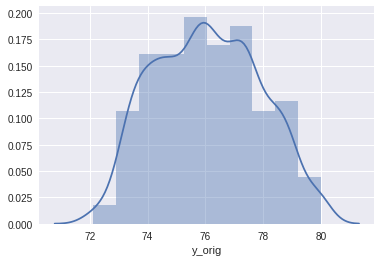

In [123]:
df_interest = df_train_eng[(df_train_eng['y_orig'] < 80)]
sns.distplot(df_interest['y_orig'], bins=10)
plt.show

In [125]:
df_interest.columns.values

array(['X8_a', 'X8_b', 'X8_c', 'X8_d', 'X8_e', 'X8_f', 'X8_g', 'X8_h',
       'X8_i', 'X8_j', 'X8_k', 'X8_l', 'X8_m', 'X8_n', 'X8_o', 'X8_p',
       'X8_q', 'X8_r', 'X8_s', 'X8_t', 'X8_u', 'X8_v', 'X8_w', 'X8_x',
       'X8_y', 'X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g',
       'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l', 'X5_a', 'X5_aa', 'X5_ab',
       'X5_ac', 'X5_ad', 'X5_ae', 'X5_af', 'X5_ag', 'X5_ah', 'X5_b',
       'X5_c', 'X5_d', 'X5_f', 'X5_g', 'X5_h', 'X5_i', 'X5_j', 'X5_k',
       'X5_l', 'X5_m', 'X5_n', 'X5_o', 'X5_p', 'X5_q', 'X5_r', 'X5_s',
       'X5_t', 'X5_u', 'X5_v', 'X5_w', 'X5_x', 'X5_y', 'X5_z', 'X4_a',
       'X4_b', 'X4_c', 'X4_d', 'X2_a', 'X2_aa', 'X2_ab', 'X2_ac', 'X2_ad',
       'X2_ae', 'X2_af', 'X2_ag', 'X2_ah', 'X2_ai', 'X2_aj', 'X2_ak',
       'X2_al', 'X2_am', 'X2_an', 'X2_ao', 'X2_ap', 'X2_aq', 'X2_ar',
       'X2_as', 'X2_at', 'X2_au', 'X2_av', 'X2_aw', 'X2_ax', 'X2_ay',
       'X2_b', 'X2_c', 'X2_d', 'X2_e', 'X2_f', 'X2_g', 'X2_h', 'X2_i',
     

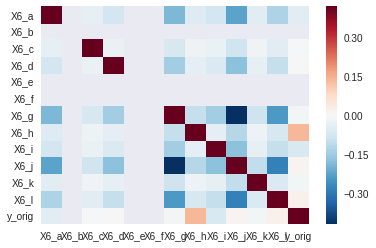

In [128]:
li_interest_col = ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l', 'y_orig']
corr = df_interest[li_interest_col].corr()
sns.heatmap(corr, vmax=.2)
plt.show()

Now that is interesting: 0 correlation on diagonal for X6_b, e and f

In [129]:
df_interest[li_interest_col].describe()

,X6_a,X6_b,X6_c,X6_d,X6_e,X6_f,X6_g,X6_h,X6_i,X6_j,X6_k,X6_l,y_orig
count,1562.000000,1562.0,1562.000000,1562.000000,1562.0,1562.0,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000
mean,0.091549,0.0,0.014085,0.056338,0.0,0.0,0.260563,0.028169,0.056338,0.330986,0.021127,0.140845,76.075141
std,0.288481,0.0,0.117877,0.230647,0.0,0.0,0.439083,0.165508,0.230647,0.470719,0.143853,0.347973,1.817234
min,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.110000
25%,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.620000
50%,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.955000
75%,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,77.420000
max,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,79.990000


Yep, zero values. interseting. The main weights are on g, j, l (these three account for 73.2%), with a included, that's 82.4%

In [136]:
for i in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
    print i, ' mean y_orig:',
    print df_interest[(df_interest[i] == 1)]['y_orig'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]

X6_a  mean y_orig: 75.8130769231  y_actual: 4520.37923077  Datasets: 143
X6_b  mean y_orig: nan  y_actual: nan  Datasets: 0
X6_c  mean y_orig: 76.025  y_actual: 4522.235  Datasets: 22
X6_d  mean y_orig: 76.0975  y_actual: 4981.64958333  Datasets: 88
X6_e  mean y_orig: nan  y_actual: nan  Datasets: 0
X6_f  mean y_orig: nan  y_actual: nan  Datasets: 0
X6_g  mean y_orig: 76.0375675676  y_actual: 4355.1627027  Datasets: 407
X6_h  mean y_orig: 77.5525  y_actual: 4264.465  Datasets: 44
X6_i  mean y_orig: 75.58125  y_actual: 4229.98375  Datasets: 88
X6_j  mean y_orig: 76.1038297872  y_actual: 4790.15159574  Datasets: 517
X6_k  mean y_orig: 75.9533333333  y_actual: 4253.91  Datasets: 33
X6_l  mean y_orig: 76.164  y_actual: 4467.2045  Datasets: 220


Allthough the mean for y is very similar across the board, the y_actual (which is a product with qty_options) can be put in the following groups:<br>
- below 4300 with h, i, k<br>
- around 4500 with a, c, g, l<br>
- around 4850 with d, j
- n/a with b, e, f<br>
I like this better then having 12 distinct values, as it multiplies with X3.
## Let's repeat for higher ys:

<function matplotlib.pyplot.show>

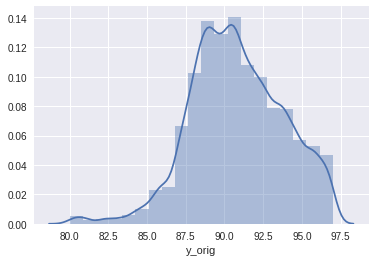

In [144]:
df_interest = df_train_eng[((df_train_eng['y_orig'] >= 80) & (df_train_eng['y_orig'] < 97))]
sns.distplot(df_interest['y_orig'], bins=20)
plt.show

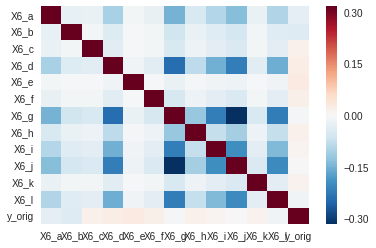

In [146]:
li_interest_col = ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l', 'y_orig']
corr = df_interest[li_interest_col].corr()
sns.heatmap(corr, vmax=.2)
plt.show()

In [145]:
for i in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
    print i, ' mean y_orig:',
    print df_interest[(df_interest[i] == 1)]['y_orig'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]

X6_a  mean y_orig: 90.4405825243  y_actual: 5322.24854369  Datasets: 1133
X6_b  mean y_orig: 89.6411111111  y_actual: 5614.165  Datasets: 198
X6_c  mean y_orig: 91.3523076923  y_actual: 5480.13846154  Datasets: 143
X6_d  mean y_orig: 90.9672764228  y_actual: 5291.83783198  Datasets: 2706
X6_e  mean y_orig: 93.355  y_actual: 5481.1  Datasets: 22
X6_f  mean y_orig: 91.3857142857  y_actual: 5754.22285714  Datasets: 154
X6_g  mean y_orig: 90.7675336323  y_actual: 5276.37490807  Datasets: 4906
X6_h  mean y_orig: 91.0373134328  y_actual: 5105.35084577  Datasets: 737
X6_i  mean y_orig: 90.8677184466  y_actual: 5288.50780744  Datasets: 2266
X6_j  mean y_orig: 90.8064659686  y_actual: 5291.4825349  Datasets: 4202
X6_k  mean y_orig: 91.2338461538  y_actual: 5992.23128205  Datasets: 143
X6_l  mean y_orig: 90.6872641509  y_actual: 4981.0852044  Datasets: 2332


Allthough the mean for y is very similar across the board (other than e), the y_actual (which is a product with qty_options) can be put in the following groups:<br>
- around 5000 with h, l<br>
- around 5300 with a, d, g, i, j<br>
- around 5500 with b, c<br>
- above 5750 with f, k<br>
- other with e<br>
I like this better then having 12 distinct values, as it multiplies with X3.

<function matplotlib.pyplot.show>

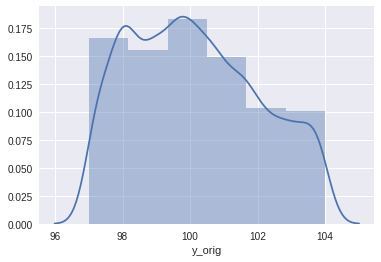

In [150]:
df_interest = df_train_eng[((df_train_eng['y_orig'] >= 97) & (df_train_eng['y_orig'] < 104))]
sns.distplot(df_interest['y_orig'], bins=6)
plt.show

In [151]:
for i in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
    print i, ' mean y_orig:',
    print df_interest[(df_interest[i] == 1)]['y_orig'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]

X6_a  mean y_orig: 100.045833333  y_actual: 5937.98708333  Datasets: 264
X6_b  mean y_orig: nan  y_actual: nan  Datasets: 0
X6_c  mean y_orig: 99.2166666667  y_actual: 6589.37666667  Datasets: 33
X6_d  mean y_orig: 100.082924528  y_actual: 5712.4658805  Datasets: 1166
X6_e  mean y_orig: 99.27  y_actual: 5559.12  Datasets: 11
X6_f  mean y_orig: 98.035  y_actual: 6130.7825  Datasets: 44
X6_g  mean y_orig: 100.032926829  y_actual: 5728.78875  Datasets: 1804
X6_h  mean y_orig: 99.7973076923  y_actual: 5235.29288462  Datasets: 286
X6_i  mean y_orig: 100.20671875  y_actual: 5717.01265625  Datasets: 704
X6_j  mean y_orig: 100.359005236  y_actual: 5658.40596859  Datasets: 2101
X6_k  mean y_orig: 100.861666667  y_actual: 6241.08166667  Datasets: 66
X6_l  mean y_orig: 100.143736264  y_actual: 5254.41139194  Datasets: 1001


Allthough the mean for y is very similar across the board, the y_actual (which is a product with qty_options) can be put in the following groups:<br>
- around 5250 with h, l<br>
- around 5700 with a, d, e, g, i, j<br>
- above 6000 with c, f, k<br>
- n/a with b<br>
I like this better then having 12 distinct values, as it multiplies with X3.

<function matplotlib.pyplot.show>

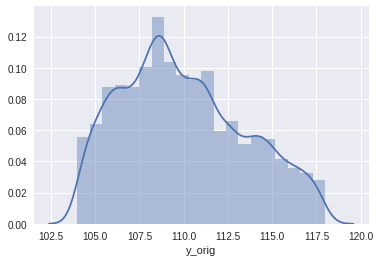

In [165]:
df_interest = df_train_eng[((df_train_eng['y_orig'] >= 104) & (df_train_eng['y_orig'] < 118))]
sns.distplot(df_interest['y_orig'], bins=20)
plt.show

In [166]:
for i in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
    print i, ' mean y_orig:',
    print df_interest[(df_interest[i] == 1)]['y_orig'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]

X6_a  mean y_orig: 109.576981132  y_actual: 6539.18415094  Datasets: 583
X6_b  mean y_orig: 111.305  y_actual: 6927.82520833  Datasets: 88
X6_c  mean y_orig: 109.170588235  y_actual: 6498.74764706  Datasets: 187
X6_d  mean y_orig: 110.206812227  y_actual: 6634.91365357  Datasets: 2519
X6_e  mean y_orig: 110.38  y_actual: 6925.12333333  Datasets: 66
X6_f  mean y_orig: 112.375  y_actual: 7139.75  Datasets: 22
X6_g  mean y_orig: 110.071132075  y_actual: 6564.343674  Datasets: 3498
X6_h  mean y_orig: 109.773428571  y_actual: 6600.85788095  Datasets: 770
X6_i  mean y_orig: 109.991551724  y_actual: 6506.28673372  Datasets: 1914
X6_j  mean y_orig: 110.21840708  y_actual: 6484.23831016  Datasets: 3729
X6_k  mean y_orig: 110.170526316  y_actual: 6786.51789474  Datasets: 209
X6_l  mean y_orig: 109.104552239  y_actual: 6075.54988806  Datasets: 1474


Allthough the mean for y is very similar across the board, the y_actual (which is a product with qty_options) can be put in the following groups:<br>
- around 6100 with l<br>
- around 6500 with a, c, i, j<br>
- around 6600 with d, g, h<br>
- above 6700 with b, e, f, k<br>
I like this better then having 12 distinct values, as it multiplies with X3.

<function matplotlib.pyplot.show>

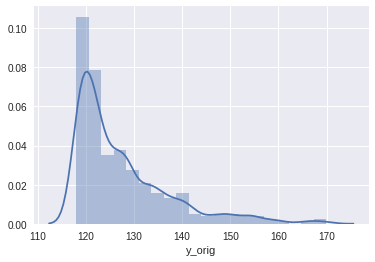

In [167]:
df_interest = df_train_eng[(df_train_eng['y_orig'] >= 118)]
sns.distplot(df_interest['y_orig'], bins=20)
plt.show

In [168]:
for i in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
    print i, ' mean y_orig:',
    print df_interest[(df_interest[i] == 1)]['y_orig'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]

X6_a  mean y_orig: 125.976153846  y_actual: 7025.69846154  Datasets: 143
X6_b  mean y_orig: 130.01  y_actual: 8613.9  Datasets: 22
X6_c  mean y_orig: 149.5  y_actual: 9418.42333333  Datasets: 33
X6_d  mean y_orig: 125.240555556  y_actual: 7803.04888889  Datasets: 396
X6_e  mean y_orig: 122.92  y_actual: 6933.89  Datasets: 33
X6_f  mean y_orig: nan  y_actual: nan  Datasets: 0
X6_g  mean y_orig: 127.472987013  y_actual: 7326.32313853  Datasets: 847
X6_h  mean y_orig: 126.393043478  y_actual: 7911.62891304  Datasets: 253
X6_i  mean y_orig: 125.653333333  y_actual: 7519.72708333  Datasets: 396
X6_j  mean y_orig: 128.914125  y_actual: 7476.51773214  Datasets: 880
X6_k  mean y_orig: 138.455  y_actual: 8406.64  Datasets: 22
X6_l  mean y_orig: 127.428  y_actual: 6834.76225  Datasets: 220


Allthough the mean for y is all over the board and could be put into groups, let's stay with y_actual for consitency, which gives the following groups:<br>
- below 7000 with e, l<br>
- between 7000 and 7600 with a, g, i, j<br>
- between 7600 and  with d, h, b, k<br>
- n/a with f
I like this better then having 12 distinct values, as it multiplies with X3.

## let's put this all together:



In [174]:
df_interest = df_train_eng
matrix = []
for j in [df_train_eng_0, df_train_eng_1, df_train_eng_3, df_train_eng_5]:
    df_interest = j
    matrix_sub = []
    for i in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
        matrix_sub.append(df_interest[(df_interest[i] == 1)].shape[0])
        print i, ' mean y_orig:',
        print df_interest[(df_interest[i] == 1)]['y_orig'].mean(), ' y_actual:',
        print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), ' Datasets:',
        print matrix_sub[len(matrix_sub) -1]
    matrix.append(matrix_sub)
    print '\n'
print matrix

X6_a  mean y_orig: 99.8147747748  y_actual: 6080.72536036  Datasets: 1221
X6_b  mean y_orig: 100.512857143  y_actual: 6449.22531746  Datasets: 231
X6_c  mean y_orig: 104.801923077  y_actual: 6496.08615385  Datasets: 286
X6_d  mean y_orig: 102.5544  y_actual: 6275.07968571  Datasets: 3850
X6_e  mean y_orig: 108.733333333  y_actual: 6659.445  Datasets: 66
X6_f  mean y_orig: 90.35  y_actual: 5692.05  Datasets: 11
X6_g  mean y_orig: 101.534099822  y_actual: 6092.88564765  Datasets: 6171
X6_h  mean y_orig: 104.225702479  y_actual: 6388.24566116  Datasets: 1331
X6_i  mean y_orig: 101.553577982  y_actual: 6114.09266055  Datasets: 2398
X6_j  mean y_orig: 102.643514329  y_actual: 6167.20697192  Datasets: 7293
X6_k  mean y_orig: 104.133043478  y_actual: 6670.54782609  Datasets: 253
X6_l  mean y_orig: 101.060533808  y_actual: 5794.77285884  Datasets: 3091


X6_a  mean y_orig: 101.771153846  y_actual: 5848.07160256  Datasets: 286
X6_b  mean y_orig: 100.34  y_actual: 5911.47  Datasets: 22
X6_c  mea

In [208]:
matrix_np = np.array(matrix)
summ = matrix_np.sum()
matrix_np_fl = matrix_np.view('float64')
matrix_np_fl[:] = matrix_np
matrix_np_fl = matrix_np_fl / summ

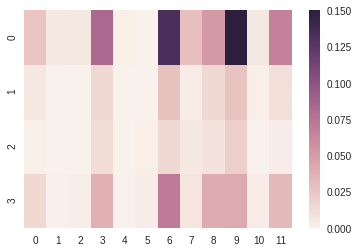

In [215]:
sns.heatmap(matrix_np_fl, vmax = .15)
plt.show()

In [217]:
df_interest = df_train_eng
for i in ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l']:
    print i, ' mean y_orig:',
    print df_interest[(df_interest[i] == 1)]['y_orig'].mean(), ' y_actual:',
    print df_interest[(df_interest[i] == 1)]['y_actual'].mean(), ' Datasets:',
    print df_interest[(df_interest[i] == 1)].shape[0]

X6_a  mean y_orig: 97.8025242718  y_actual: 5763.97601942  Datasets: 2266
X6_b  mean y_orig: 98.7142857143  y_actual: 6203.76327381  Datasets: 308
X6_c  mean y_orig: 103.728421053  y_actual: 6283.90473684  Datasets: 418
X6_d  mean y_orig: 101.346464  y_actual: 5995.95467733  Datasets: 6875
X6_e  mean y_orig: 109.751666667  y_actual: 6572.81083333  Datasets: 132
X6_f  mean y_orig: 94.8145  y_actual: 5968.0875  Datasets: 220
X6_g  mean y_orig: 100.306285988  y_actual: 5859.41819002  Datasets: 11462
X6_h  mean y_orig: 103.134842105  y_actual: 5996.11314912  Datasets: 2090
X6_i  mean y_orig: 101.226803279  y_actual: 5926.15851434  Datasets: 5368
X6_j  mean y_orig: 101.165245428  y_actual: 5893.66429167  Datasets: 11429
X6_k  mean y_orig: 102.074883721  y_actual: 6368.93829457  Datasets: 473
X6_l  mean y_orig: 98.5967085954  y_actual: 5396.8648218  Datasets: 5247


In [ ]:
df_test_eng_a = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2) | (df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & ((df_test_eng['X6_a'] == 1) | (df_test_eng['X6_b'] == 1)))]
df_test_eng_b = df_test_eng[(((df_test_eng['X3'] == 3) & ((df_test_eng['X6_a'] == 1) | (df_test_eng['X6_b'] == 1))) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2) | (df_test_eng['X3'] == 3) | (df_test_eng['X3'] == 5)) & (df_test_eng['X6_e'] == 1)) | ((df_test_eng['X3'] == 3) & (df_test_eng['X6_k'] == 1)) | ((df_test_eng['X3'] == 3) & ((df_test_eng['X6_d'] == 1) | (df_test_eng['X6_g'] == 1) | (df_test_eng['X6_i'] == 1))))]
df_test_eng_c = df_test_eng[(((df_test_eng['X3'] == 5) & ((df_test_eng['X6_a'] == 1) | (df_test_eng['X6_b'] == 1))) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_f'] == 1)))]

df_test_eng_d = df_test_eng[((((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2) | (df_test_eng['X3'] == 5)) & (df_test_eng['X6_c'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_h'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_k'] == 1)) | ((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & (df_test_eng['X6_e'] == 1)) | ((df_test_eng['X3'] == 3) & ((df_test_eng['X6_h'] == 1) | (df_test_eng['X6_j'] == 1)))]
df_test_eng_e = df_test_eng[((((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & ((df_test_eng['X6_c'] == 1) | (df_test_eng['X6_k'] == 1))) | ((df_test_eng['X3'] == 3) & ((df_test_eng['X6_c'] == 1) | (df_test_eng['X6_f'] == 1) | (df_test_eng['X6_l'] == 1))) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_f'] == 1)) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_d'] == 1)) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_g'] == 1)) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_j'] == 1)) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_l'] == 1)))]
#df_test_eng_f = df_test_eng[((df_test_eng['X3'] == 5) & (df_test_eng['X6_d'] == 1))]

#df_test_eng_g = df_test_eng[((df_test_eng['X3'] == 5) & (df_test_eng['X6_g'] == 1))]
#df_test_eng_h = df_test_eng[((df_test_eng['X3'] == 5) & (df_test_eng['X6_j'] == 1))]
#df_test_eng_i = df_test_eng[((df_test_eng['X3'] == 5) & (df_test_eng['X6_l'] == 1))]

df_test_eng_j = df_test_eng[((((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_d'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_j'] == 1)))]
df_test_eng_k = df_test_eng[((((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & ((df_test_eng['X6_d'] == 1) | (df_test_eng['X6_h'] == 1) | (df_test_eng['X6_i'] == 1))) | ((df_test_eng['X3'] == 5) & ((df_test_eng['X6_h'] == 1) | (df_test_eng['X6_i'] == 1) | (df_test_eng['X6_k'] == 1))))]
#df_test_eng_l = df_test_eng[((df_test_eng['X3'] == 3) & ((df_test_eng['X6_d'] == 1) | (df_test_eng['X6_g'] == 1) | (df_test_eng['X6_i'] == 1)))]

#df_test_eng_m = df_test_eng[((((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2) | (df_test_eng['X3'] == 3) | (df_test_eng['X3'] == 5)) & (df_test_eng['X6_e'] == 1)) | ((df_test_eng['X3'] == 3) & (df_test_eng['X6_k'] == 1)))]
df_test_eng_n = df_test_eng[((((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & (df_test_eng['X6_g'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_g'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_l'] == 1)))]
#df_test_eng_o = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_g'] == 1))]

df_test_eng_p = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_i'] == 1))]
#df_test_eng_q = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_h'] == 1))]
#df_test_eng_r = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_j'] == 1))]

#df_test_eng_s = df_test_eng[((((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_k'] == 1)) | ((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & (df_test_eng['X6_e'] == 1)) | ((df_test_eng['X3'] == 3) & ((df_test_eng['X6_h'] == 1) | (df_test_eng['X6_j'] == 1)))]
#df_test_eng_t = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_l'] == 1))]
df_test_eng_u = df_test_eng[(((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & ((df_test_eng['X6_j'] == 1) | (df_test_eng['X6_l'] == 1)))]
#li_all_test = [df_test_eng_a, df_test_eng_b, df_test_eng_c, df_test_eng_d, df_test_eng_e, df_test_eng_f, df_test_eng_g, df_test_eng_h, df_test_eng_i, df_test_eng_j, df_test_eng_k, df_test_eng_l, df_test_eng_m, df_test_eng_n, df_test_eng_o, df_test_eng_p, df_test_eng_q, df_test_eng_r, df_test_eng_s, df_test_eng_t, df_test_eng_u]
li_all_test = [df_test_eng_a, df_test_eng_b, df_test_eng_c, df_test_eng_d, df_test_eng_e, df_test_eng_j, df_test_eng_k, df_test_eng_n, df_test_eng_p, df_test_eng_u]

df_train_eng_a = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2) | (df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & ((df_train_eng['X6_a'] == 1) | (df_train_eng['X6_b'] == 1)))]
df_train_eng_b = df_train_eng[(((df_train_eng['X3'] == 3) & ((df_train_eng['X6_a'] == 1) | (df_train_eng['X6_b'] == 1))) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2) | (df_train_eng['X3'] == 3) | (df_train_eng['X3'] == 5)) & (df_train_eng['X6_e'] == 1)) | ((df_train_eng['X3'] == 3) & (df_train_eng['X6_k'] == 1)) | ((df_train_eng['X3'] == 3) & ((df_train_eng['X6_d'] == 1) | (df_train_eng['X6_g'] == 1) | (df_train_eng['X6_i'] == 1))))]
df_train_eng_c = df_train_eng[(((df_train_eng['X3'] == 5) & ((df_train_eng['X6_a'] == 1) | (df_train_eng['X6_b'] == 1))) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_f'] == 1)))]
df_train_eng_d = df_train_eng[((((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2) | (df_train_eng['X3'] == 5)) & (df_train_eng['X6_c'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_h'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_k'] == 1)) | ((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & (df_train_eng['X6_e'] == 1)) | ((df_train_eng['X3'] == 3) & ((df_train_eng['X6_h'] == 1) | (df_train_eng['X6_j'] == 1)))]
df_train_eng_e = df_train_eng[((((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & ((df_train_eng['X6_c'] == 1) | (df_train_eng['X6_k'] == 1))) | ((df_train_eng['X3'] == 3) & ((df_train_eng['X6_c'] == 1) | (df_train_eng['X6_f'] == 1) | (df_train_eng['X6_l'] == 1))) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_f'] == 1)) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_d'] == 1)) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_g'] == 1)) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_j'] == 1)) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_l'] == 1)))]
#df_train_eng_f = df_train_eng[((df_train_eng['X3'] == 5) & (df_train_eng['X6_d'] == 1))]
#df_train_eng_g = df_train_eng[((df_train_eng['X3'] == 5) & (df_train_eng['X6_g'] == 1))]
#df_train_eng_h = df_train_eng[((df_train_eng['X3'] == 5) & (df_train_eng['X6_j'] == 1))]
#df_train_eng_i = df_train_eng[((df_train_eng['X3'] == 5) & (df_train_eng['X6_l'] == 1))]
df_train_eng_j = df_train_eng[((((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_d'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_j'] == 1)))]
df_train_eng_k = df_train_eng[((((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & ((df_train_eng['X6_d'] == 1) | (df_train_eng['X6_h'] == 1) | (df_train_eng['X6_i'] == 1))) | ((df_train_eng['X3'] == 5) & ((df_train_eng['X6_h'] == 1) | (df_train_eng['X6_i'] == 1) | (df_train_eng['X6_k'] == 1))))]
#df_train_eng_l = df_train_eng[((df_train_eng['X3'] == 3) & ((df_train_eng['X6_d'] == 1) | (df_train_eng['X6_g'] == 1) | (df_train_eng['X6_i'] == 1)))]
#df_train_eng_m = df_train_eng[((((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2) | (df_train_eng['X3'] == 3) | (df_train_eng['X3'] == 5)) & (df_train_eng['X6_e'] == 1)) | ((df_train_eng['X3'] == 3) & (df_train_eng['X6_k'] == 1)))]
df_train_eng_n = df_train_eng[((((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & (df_train_eng['X6_g'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_g'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_l'] == 1)))]
#df_train_eng_o = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_g'] == 1))]
df_train_eng_p = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_i'] == 1))]
#df_train_eng_q = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_h'] == 1))]
#df_train_eng_r = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_j'] == 1))]
#df_train_eng_s = df_train_eng[((((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_k'] == 1)) | ((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & (df_train_eng['X6_e'] == 1)) | ((df_train_eng['X3'] == 3) & ((df_train_eng['X6_h'] == 1) | (df_train_eng['X6_j'] == 1)))]
#df_train_eng_t = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_l'] == 1))]
df_train_eng_u = df_train_eng[(((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & ((df_train_eng['X6_j'] == 1) | (df_train_eng['X6_l'] == 1)))]
#li_all_train = [df_train_eng_a, df_train_eng_b, df_train_eng_c, df_train_eng_d, df_train_eng_e, df_train_eng_f, df_train_eng_g, df_train_eng_h, df_train_eng_i, df_train_eng_j, df_train_eng_k, df_train_eng_l, df_train_eng_m, df_train_eng_n, df_train_eng_o, df_train_eng_p, df_train_eng_q, df_train_eng_r, df_train_eng_s, df_train_eng_t, df_train_eng_u]
li_all_train = [df_train_eng_a, df_train_eng_b, df_train_eng_c, df_train_eng_d, df_train_eng_e, df_train_eng_j, df_train_eng_k, df_train_eng_n, df_train_eng_p, df_train_eng_u]



[mean: 0.90918, std: 0.00298, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.90965, std: 0.00336, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
0 :  0.901859925055


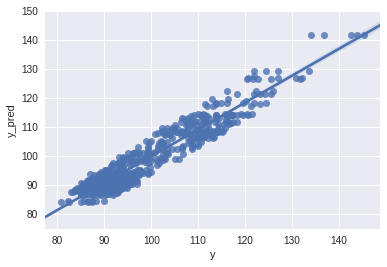

[mean: 0.82566, std: 0.01712, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.82544, std: 0.01679, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
1 :  0.799689724015


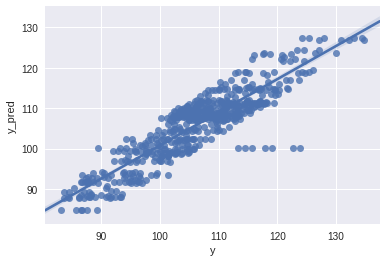

[mean: 0.93537, std: 0.00475, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.93563, std: 0.00515, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
2 :  0.943004555603


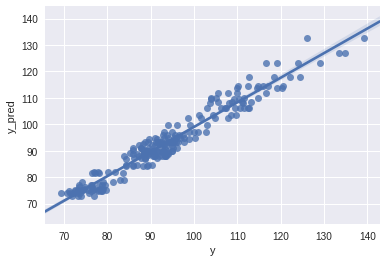

[mean: 0.84054, std: 0.03475, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.83996, std: 0.03497, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
3 :  0.845532342967


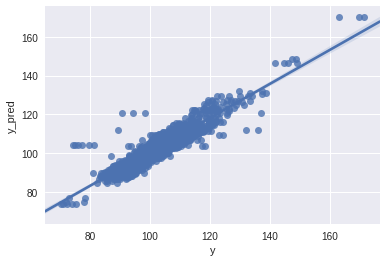

[mean: 0.88794, std: 0.00504, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.88899, std: 0.00526, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
4 :  0.884799776107


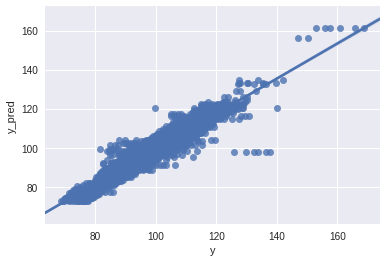

[mean: 0.87747, std: 0.00360, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.87856, std: 0.00353, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
5 :  0.876957691435


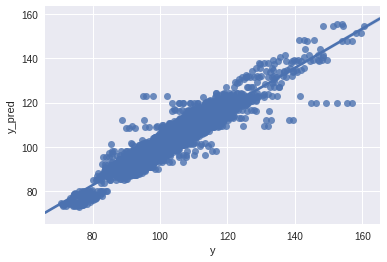

[mean: 0.90911, std: 0.00377, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.90887, std: 0.00375, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
6 :  0.908423812755


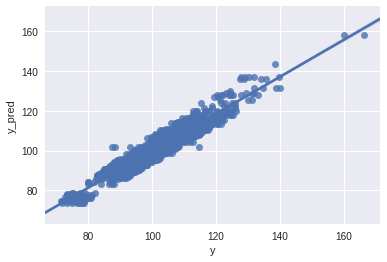

[mean: 0.84499, std: 0.00851, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.84634, std: 0.00904, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
7 :  0.849425572963


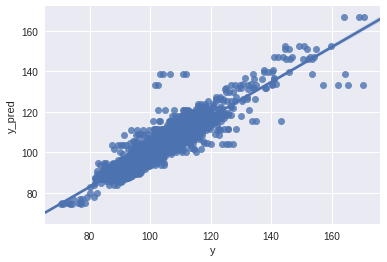

[mean: 0.91067, std: 0.00901, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.91041, std: 0.00878, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
8 :  0.910494218213


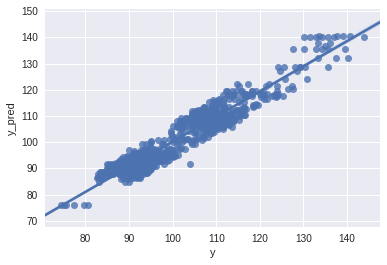

[mean: 0.89111, std: 0.01034, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.89086, std: 0.00985, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
9 :  0.908670635129


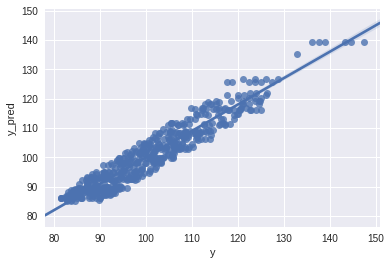

all:  0.881588285678


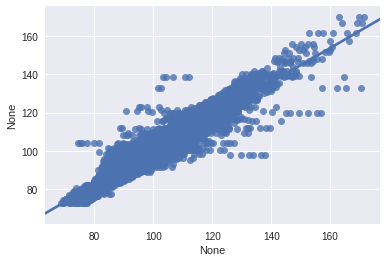

In [245]:
list_index = list(df_test_eng.columns.values)
#li_remove = ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l', 'y', 'X3']
li_remove = ['y', 'X3']
for x in li_remove:
    list_index.remove(x)
list_test = list_index
list_train = ['y'] + list_test
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()
cv_params = {'max_depth': [7], 'min_child_weight': [5], 'n_estimators': [400, 600]}
ind_params = {'learning_rate': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8}

for i in range(len(li_all_test)):
    df_X = li_all_train[i][list_train]
    df_Kaggle = li_all_test[i][list_test]
    df_y = df_X['y']
    df_X = df_X.drop('y', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

    model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
    model.fit(X_train, y_train)
    print model.grid_scores_
    y_pred = pd.Series(model.predict(X_test), name='y_pred', index=X_test.index)
    y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
    y_pred_all = y_pred_all.append(y_pred)
    y_test_all = y_test_all.append(y_test)
    df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
    y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
    print i, ': ', r2_score(y_test, y_pred)
    sns.regplot(y_test, y_pred)
    plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all, name='y', index=df_Kaggle_all.index)
output_Kaggle.to_csv(path='../data/20170618.2200.a_to_u_models.xgboost.csv', index_label='ID', header = True)

## Combining bove 0, 2, 6, 8, 9 into one

In [246]:
df_test_eng_a = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2) | (df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & ((df_test_eng['X6_a'] == 1) | (df_test_eng['X6_b'] == 1)))]
df_test_eng_b = df_test_eng[(((df_test_eng['X3'] == 3) & ((df_test_eng['X6_a'] == 1) | (df_test_eng['X6_b'] == 1))) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2) | (df_test_eng['X3'] == 3) | (df_test_eng['X3'] == 5)) & (df_test_eng['X6_e'] == 1)) | ((df_test_eng['X3'] == 3) & (df_test_eng['X6_k'] == 1)) | ((df_test_eng['X3'] == 3) & ((df_test_eng['X6_d'] == 1) | (df_test_eng['X6_g'] == 1) | (df_test_eng['X6_i'] == 1))))]
df_test_eng_c = df_test_eng[(((df_test_eng['X3'] == 5) & ((df_test_eng['X6_a'] == 1) | (df_test_eng['X6_b'] == 1))) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_f'] == 1)))]

df_test_eng_d = df_test_eng[((((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2) | (df_test_eng['X3'] == 5)) & (df_test_eng['X6_c'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_h'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_k'] == 1)) | ((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & (df_test_eng['X6_e'] == 1)) | ((df_test_eng['X3'] == 3) & ((df_test_eng['X6_h'] == 1) | (df_test_eng['X6_j'] == 1)))]
df_test_eng_e = df_test_eng[((((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & ((df_test_eng['X6_c'] == 1) | (df_test_eng['X6_k'] == 1))) | ((df_test_eng['X3'] == 3) & ((df_test_eng['X6_c'] == 1) | (df_test_eng['X6_f'] == 1) | (df_test_eng['X6_l'] == 1))) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_f'] == 1)) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_d'] == 1)) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_g'] == 1)) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_j'] == 1)) | ((df_test_eng['X3'] == 5) & (df_test_eng['X6_l'] == 1)))]
#df_test_eng_f = df_test_eng[((df_test_eng['X3'] == 5) & (df_test_eng['X6_d'] == 1))]

#df_test_eng_g = df_test_eng[((df_test_eng['X3'] == 5) & (df_test_eng['X6_g'] == 1))]
#df_test_eng_h = df_test_eng[((df_test_eng['X3'] == 5) & (df_test_eng['X6_j'] == 1))]
#df_test_eng_i = df_test_eng[((df_test_eng['X3'] == 5) & (df_test_eng['X6_l'] == 1))]

df_test_eng_j = df_test_eng[((((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_d'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_j'] == 1)))]
df_test_eng_k = df_test_eng[((((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & ((df_test_eng['X6_d'] == 1) | (df_test_eng['X6_h'] == 1) | (df_test_eng['X6_i'] == 1))) | ((df_test_eng['X3'] == 5) & ((df_test_eng['X6_h'] == 1) | (df_test_eng['X6_i'] == 1) | (df_test_eng['X6_k'] == 1))))]
#df_test_eng_l = df_test_eng[((df_test_eng['X3'] == 3) & ((df_test_eng['X6_d'] == 1) | (df_test_eng['X6_g'] == 1) | (df_test_eng['X6_i'] == 1)))]

#df_test_eng_m = df_test_eng[((((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2) | (df_test_eng['X3'] == 3) | (df_test_eng['X3'] == 5)) & (df_test_eng['X6_e'] == 1)) | ((df_test_eng['X3'] == 3) & (df_test_eng['X6_k'] == 1)))]
df_test_eng_n = df_test_eng[((((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & (df_test_eng['X6_g'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_g'] == 1)) | (((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_l'] == 1)))]
#df_test_eng_o = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_g'] == 1))]

df_test_eng_p = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_i'] == 1))]
#df_test_eng_q = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_h'] == 1))]
#df_test_eng_r = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_j'] == 1))]

#df_test_eng_s = df_test_eng[((((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_k'] == 1)) | ((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & (df_test_eng['X6_e'] == 1)) | ((df_test_eng['X3'] == 3) & ((df_test_eng['X6_h'] == 1) | (df_test_eng['X6_j'] == 1)))]
#df_test_eng_t = df_test_eng[(((df_test_eng['X3'] == 0) | (df_test_eng['X3'] == 2)) & (df_test_eng['X6_l'] == 1))]
df_test_eng_u = df_test_eng[(((df_test_eng['X3'] == 1) | (df_test_eng['X3'] == 4) | (df_test_eng['X3'] == 6)) & ((df_test_eng['X6_j'] == 1) | (df_test_eng['X6_l'] == 1)))]
#li_all_test = [df_test_eng_a, df_test_eng_b, df_test_eng_c, df_test_eng_d, df_test_eng_e, df_test_eng_f, df_test_eng_g, df_test_eng_h, df_test_eng_i, df_test_eng_j, df_test_eng_k, df_test_eng_l, df_test_eng_m, df_test_eng_n, df_test_eng_o, df_test_eng_p, df_test_eng_q, df_test_eng_r, df_test_eng_s, df_test_eng_t, df_test_eng_u]
df_test_eng_a = pd.concat([df_test_eng_a, df_test_eng_c, df_test_eng_k, df_test_eng_p, df_test_eng_u], axis = 0)
li_all_test = [df_test_eng_a, df_test_eng_b, df_test_eng_d, df_test_eng_e, df_test_eng_j, df_test_eng_n]

df_train_eng_a = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2) | (df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & ((df_train_eng['X6_a'] == 1) | (df_train_eng['X6_b'] == 1)))]
df_train_eng_b = df_train_eng[(((df_train_eng['X3'] == 3) & ((df_train_eng['X6_a'] == 1) | (df_train_eng['X6_b'] == 1))) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2) | (df_train_eng['X3'] == 3) | (df_train_eng['X3'] == 5)) & (df_train_eng['X6_e'] == 1)) | ((df_train_eng['X3'] == 3) & (df_train_eng['X6_k'] == 1)) | ((df_train_eng['X3'] == 3) & ((df_train_eng['X6_d'] == 1) | (df_train_eng['X6_g'] == 1) | (df_train_eng['X6_i'] == 1))))]
df_train_eng_c = df_train_eng[(((df_train_eng['X3'] == 5) & ((df_train_eng['X6_a'] == 1) | (df_train_eng['X6_b'] == 1))) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_f'] == 1)))]
df_train_eng_d = df_train_eng[((((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2) | (df_train_eng['X3'] == 5)) & (df_train_eng['X6_c'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_h'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_k'] == 1)) | ((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & (df_train_eng['X6_e'] == 1)) | ((df_train_eng['X3'] == 3) & ((df_train_eng['X6_h'] == 1) | (df_train_eng['X6_j'] == 1)))]
df_train_eng_e = df_train_eng[((((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & ((df_train_eng['X6_c'] == 1) | (df_train_eng['X6_k'] == 1))) | ((df_train_eng['X3'] == 3) & ((df_train_eng['X6_c'] == 1) | (df_train_eng['X6_f'] == 1) | (df_train_eng['X6_l'] == 1))) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_f'] == 1)) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_d'] == 1)) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_g'] == 1)) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_j'] == 1)) | ((df_train_eng['X3'] == 5) & (df_train_eng['X6_l'] == 1)))]
#df_train_eng_f = df_train_eng[((df_train_eng['X3'] == 5) & (df_train_eng['X6_d'] == 1))]
#df_train_eng_g = df_train_eng[((df_train_eng['X3'] == 5) & (df_train_eng['X6_g'] == 1))]
#df_train_eng_h = df_train_eng[((df_train_eng['X3'] == 5) & (df_train_eng['X6_j'] == 1))]
#df_train_eng_i = df_train_eng[((df_train_eng['X3'] == 5) & (df_train_eng['X6_l'] == 1))]
df_train_eng_j = df_train_eng[((((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_d'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_j'] == 1)))]
df_train_eng_k = df_train_eng[((((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & ((df_train_eng['X6_d'] == 1) | (df_train_eng['X6_h'] == 1) | (df_train_eng['X6_i'] == 1))) | ((df_train_eng['X3'] == 5) & ((df_train_eng['X6_h'] == 1) | (df_train_eng['X6_i'] == 1) | (df_train_eng['X6_k'] == 1))))]
#df_train_eng_l = df_train_eng[((df_train_eng['X3'] == 3) & ((df_train_eng['X6_d'] == 1) | (df_train_eng['X6_g'] == 1) | (df_train_eng['X6_i'] == 1)))]
#df_train_eng_m = df_train_eng[((((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2) | (df_train_eng['X3'] == 3) | (df_train_eng['X3'] == 5)) & (df_train_eng['X6_e'] == 1)) | ((df_train_eng['X3'] == 3) & (df_train_eng['X6_k'] == 1)))]
df_train_eng_n = df_train_eng[((((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & (df_train_eng['X6_g'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_g'] == 1)) | (((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_l'] == 1)))]
#df_train_eng_o = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_g'] == 1))]
df_train_eng_p = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_i'] == 1))]
#df_train_eng_q = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_h'] == 1))]
#df_train_eng_r = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_j'] == 1))]
#df_train_eng_s = df_train_eng[((((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_k'] == 1)) | ((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & (df_train_eng['X6_e'] == 1)) | ((df_train_eng['X3'] == 3) & ((df_train_eng['X6_h'] == 1) | (df_train_eng['X6_j'] == 1)))]
#df_train_eng_t = df_train_eng[(((df_train_eng['X3'] == 0) | (df_train_eng['X3'] == 2)) & (df_train_eng['X6_l'] == 1))]
df_train_eng_u = df_train_eng[(((df_train_eng['X3'] == 1) | (df_train_eng['X3'] == 4) | (df_train_eng['X3'] == 6)) & ((df_train_eng['X6_j'] == 1) | (df_train_eng['X6_l'] == 1)))]
#li_all_train = [df_train_eng_a, df_train_eng_b, df_train_eng_c, df_train_eng_d, df_train_eng_e, df_train_eng_f, df_train_eng_g, df_train_eng_h, df_train_eng_i, df_train_eng_j, df_train_eng_k, df_train_eng_l, df_train_eng_m, df_train_eng_n, df_train_eng_o, df_train_eng_p, df_train_eng_q, df_train_eng_r, df_train_eng_s, df_train_eng_t, df_train_eng_u]
df_train_eng_a = pd.concat([df_train_eng_a, df_train_eng_c, df_train_eng_k, df_train_eng_p, df_train_eng_u], axis = 0)
li_all_train = [df_train_eng_a, df_train_eng_b, df_train_eng_d, df_train_eng_e, df_train_eng_j, df_train_eng_n]


[mean: 0.90895, std: 0.00239, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.91039, std: 0.00179, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
0 :  0.915776079622


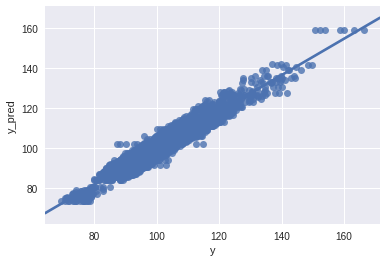

[mean: 0.82566, std: 0.01712, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.82544, std: 0.01679, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
1 :  0.799689724015


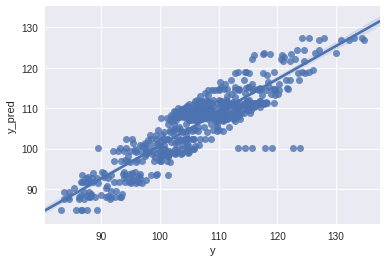

[mean: 0.84054, std: 0.03475, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.83996, std: 0.03497, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
2 :  0.845532342967


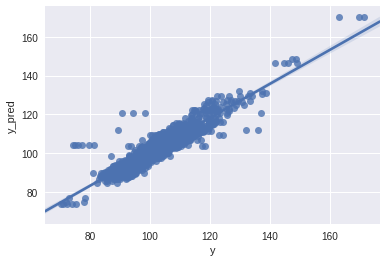

[mean: 0.88794, std: 0.00504, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.88899, std: 0.00526, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
3 :  0.884799776107


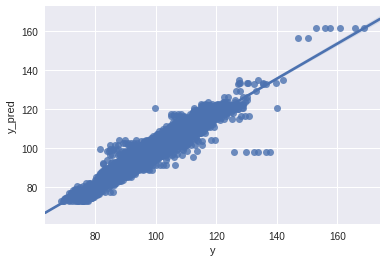

[mean: 0.87747, std: 0.00360, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.87856, std: 0.00353, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
4 :  0.876957691435


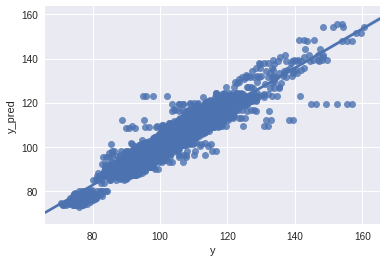

[mean: 0.84499, std: 0.00851, params: {'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 5}, mean: 0.84634, std: 0.00904, params: {'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 5}]
5 :  0.849425572963


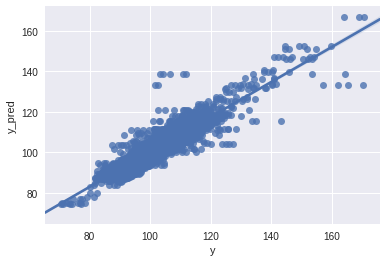

all:  0.882466323004


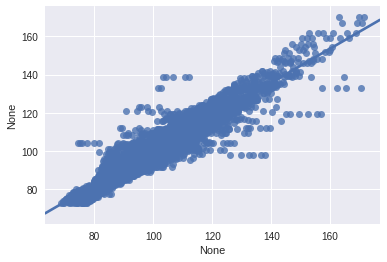

In [247]:
list_index = list(df_test_eng.columns.values)
#li_remove = ['X6_a', 'X6_b', 'X6_c', 'X6_d', 'X6_e', 'X6_f', 'X6_g', 'X6_h', 'X6_i', 'X6_j', 'X6_k', 'X6_l', 'y', 'X3']
li_remove = ['y', 'X3']
for x in li_remove:
    list_index.remove(x)
list_test = list_index
list_train = ['y'] + list_test
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()
cv_params = {'max_depth': [7], 'min_child_weight': [5], 'n_estimators': [400, 600]}
ind_params = {'learning_rate': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8}

for i in range(len(li_all_test)):
    df_X = li_all_train[i][list_train]
    df_Kaggle = li_all_test[i][list_test]
    df_y = df_X['y']
    df_X = df_X.drop('y', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

    model = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'r2', cv = 5) 
    model.fit(X_train, y_train)
    print model.grid_scores_
    y_pred = pd.Series(model.predict(X_test), name='y_pred', index=X_test.index)
    y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
    y_pred_all = y_pred_all.append(y_pred)
    y_test_all = y_test_all.append(y_test)
    df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
    y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
    print i, ': ', r2_score(y_test, y_pred)
    sns.regplot(y_test, y_pred)
    plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all, name='y', index=df_Kaggle_all.index)
output_Kaggle.to_csv(path='../data/20170618.2200.a_to_u_models.xgboost.csv', index_label='ID', header = True)

to-dos:
+ make different dataframes: use the mean / making new data for training data, and use 100% of the original training data as test data to tune the models<br>
+ make X3 data dummy, and change everything below.<br>
+ finetune the data parcels.<br>
+ finetune the individual models.